# Streamflow and precipitation data from Boulder Creek
Grouping and aggregating data - answer key

## Setup and import data

In [2]:
# Libraries used in this demo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data file path
streamflow_pth = './boulder_creek_streamflow_wy2010-wy2020.tsv'

# Set the plotting theme for nicer plots
sns.set(style="whitegrid")

# Increase plot resolution
%config InlineBackend.figure_format = 'retina'

First, let's import the streamflow data into pandas:

In [3]:
# Read streamflow from csv file
streamflow_names = ['agency', 'site', 'date', 'streamflow', 'code']
streamflow_df = pd.read_csv(streamflow_pth,
                            sep = '\t',
                            comment = '#',
                            # Skip header rows so pandas gets datatypes right
                            skiprows = [29, 30, 3511, 3512],
                            names = streamflow_names,
                            # Dates as datetime instead of object
                            parse_dates = ['date'],
                            usecols = ['site', 'date', 'streamflow'])

# Rename sites to upstream and downstream
streamflow_df.site = streamflow_df.site.replace(
    6727500, 'upstream').replace(
    6730200, 'downstream')

# set index
streamflow_df.set_index(['site', 'date'], inplace=True)

# Preview data
streamflow_df.head()

streamflow
site     date                  
upstream 2011-04-01        1.30
         2011-04-02        1.44
         2011-04-03        1.94
         2011-04-04        2.04
         2011-04-05        2.07

The upstream gauge only has data from April 1 to September 30 because the stream is empty or frozen at other times. For a better comparison, let's fill in those dates with 0:

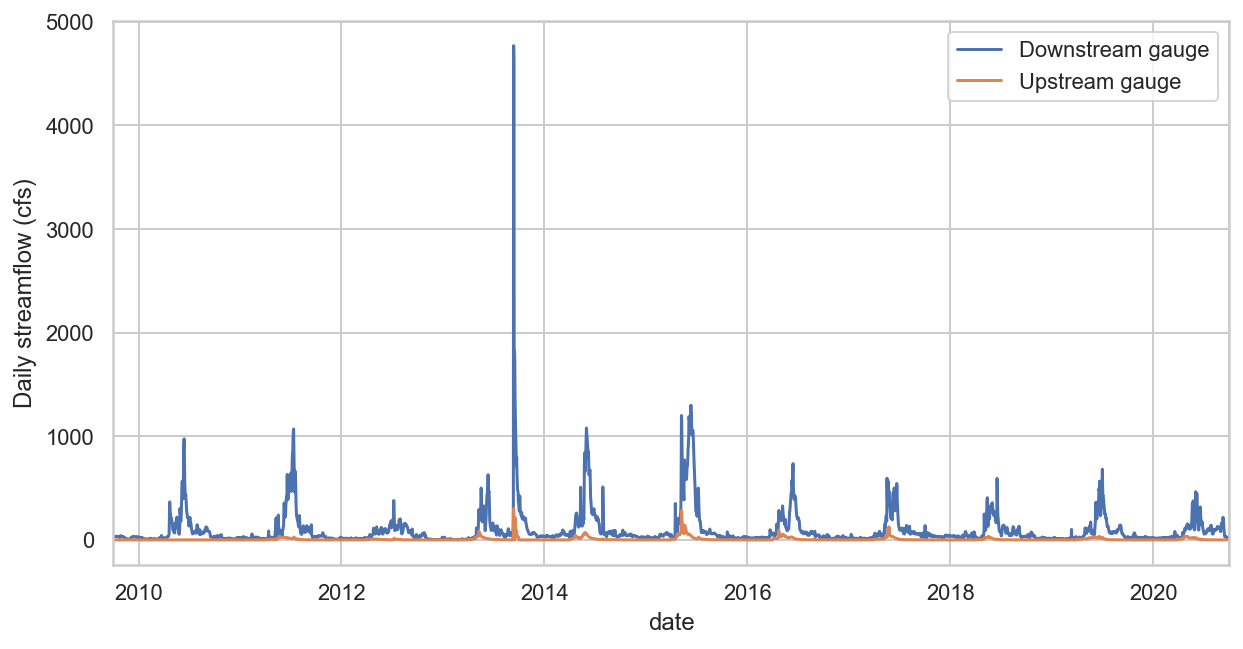

In [4]:
# Fill in missing dates for the upstream gauge with 0
downstream = streamflow_df.loc[['downstream']]
upstream = streamflow_df.loc[['upstream']].droplevel('site'
    # Include all dates in the range
    ).reindex(pd.date_range('10-01-2009', '09-30-2020')
    # Replace missing data with 0
    ).replace(np.nan, 0)

# Format the index of the upstream data to match downstream data
upstream.index = upstream.index.set_names('date')
upstream = pd.concat({'upstream': upstream}, names=['site'])
# Reassemble the filled upstream data with the downstream data
streamflow_df = pd.concat([upstream, downstream])

# Plot the data in a time series
ax = streamflow_df.unstack('site').plot(figsize = [10, 5])

# Label plot
ax.set_ylabel('Daily streamflow (cfs)')
ax.legend(labels = ('Downstream gauge', 'Upstream gauge'))

Let's take a look at a single year of data to get a better look at the data:

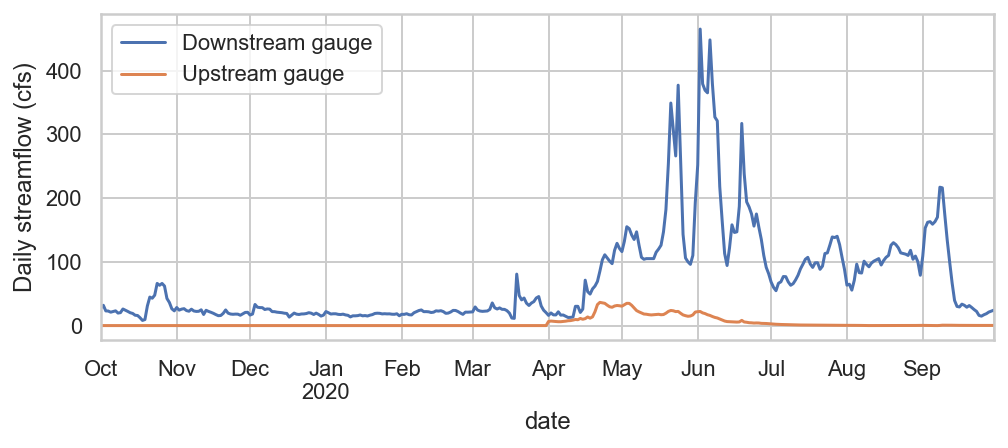

In [5]:
# Plot WY2020 (Oct 2019-Sept 2020) data only
ax = streamflow_df.loc[
    streamflow_df.index.get_level_values('date') >= '2019-10-01'
    ].unstack('site').plot(figsize = [8, 3])

# Better plot labels
ax.set_ylabel('Daily streamflow (cfs)')
ax.legend(labels = ('Downstream gauge', 'Upstream gauge'))

## How much of the streamflow at the downstream gauge comes from the upstream gauge’s branch, on average?

To calculate this value, we need to take the average streamflow for each gauge separately. We do this by *grouping* the data by site before computing the mean:

In [6]:
# Take the mean for each site separately
mean_streamflow = streamflow_df.groupby('site').agg('mean')

mean_streamflow

,streamflow
site,
downstream,98.047924
upstream,5.639691


In [7]:
# Compute the percentage
(mean_streamflow.loc['upstream'].streamflow /
    mean_streamflow.loc['downstream'].streamflow) * 100

5.75197427858542

## Is the pattern of monthly streamflow the same or different for each of these gauge locations?

To figure this out, we must group by the site AND the month of the year before averaging (or summarizing in some other way):

In [8]:
# Put the month and year in separate columns
date_idx = streamflow_df.index.get_level_values('date')
streamflow_ymd = streamflow_df.set_index(
    date_idx.month.rename('month'), append=True)
streamflow_ymd.set_index(
    date_idx.year.rename('year'), append=True, inplace=True)

streamflow_ymd

streamflow
site       date       month year            
upstream   2009-10-01 10    2009         0.0
           2009-10-02 10    2009         0.0
           2009-10-03 10    2009         0.0
           2009-10-04 10    2009         0.0
           2009-10-05 10    2009         0.0
...                                      ...
downstream 2020-09-26 9     2020        17.0
           2020-09-27 9     2020        18.6
           2020-09-28 9     2020        21.2
           2020-09-29 9     2020        22.7
           2020-09-30 9     2020        24.1

[8036 rows x 1 columns]

Remember our plot of the entire 10 years of streamflow? It was hard to see what was happening. It's common to take a look at the average monthly streamflow instead when we look at multiple years of data. To do this, we must group by not only the site, but also the month and the year of the streamflow.

In [9]:
# Calculate the total monthly streamflow
monthly_mean_streamflow = streamflow_ymd.groupby(['site', 'month', 'year']
    ).agg('mean')

# Convert the month and year back to a datetime
monthly_mean_streamflow.reset_index(['year', 'month'], inplace=True)
# Use the 15th for the day for plotting
monthly_mean_streamflow['day'] = 15
# Convert to datetime
monthly_mean_streamflow['date'] = pd.to_datetime(
    monthly_mean_streamflow[['day', 'month', 'year']])
# Set date to index level
monthly_mean_streamflow = monthly_mean_streamflow.set_index(
    'date', append=True)[['streamflow']]

# Preview data
monthly_mean_streamflow

streamflow
site       date                  
downstream 2010-01-15   15.952258
           2011-01-15   21.564516
           2012-01-15   14.547419
           2013-01-15   10.695484
           2014-01-15   33.751613
...                           ...
upstream   2015-12-15    0.000000
           2016-12-15    0.000000
           2017-12-15    0.000000
           2018-12-15    0.000000
           2019-12-15    0.000000

[264 rows x 1 columns]

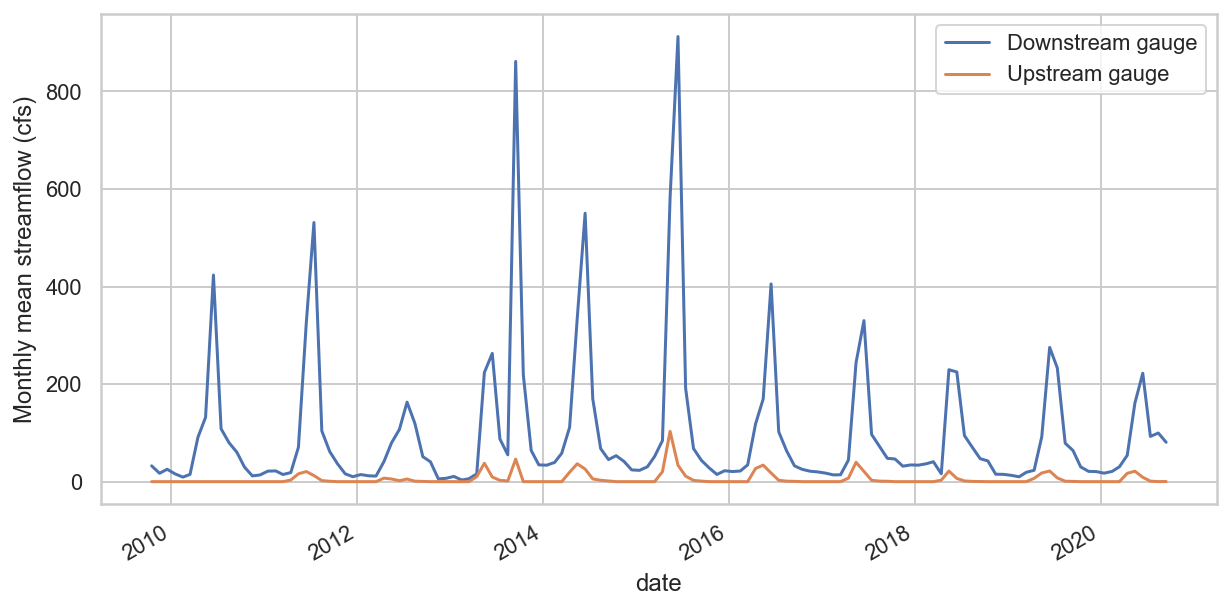

In [10]:
# Plot the monthly mean streamflow for each site
ax = monthly_mean_streamflow.unstack('site').plot(figsize=[10,5])

# Better plot labels
ax.set_ylabel('Monthly mean streamflow (cfs)')
ax.legend(labels = ('Downstream gauge', 'Upstream gauge'))

We also might want to compare the climatology of streamflow, or the *typical* (average) daily streamflow from each month of the year. To  accomplish this, what variables do we need to group by?

In [11]:
# Calculate the typical average streamflow value for each month
monthly_climatology = streamflow_ymd.groupby(['site', 'month']
    ).agg('mean')

monthly_climatology

streamflow
site       month            
downstream 1       20.194692
           2       19.958424
           3       26.852610
           4       56.201030
           5      210.834604
           6      367.252424
           7      170.086510
           8       79.848974
           9      126.852970
           10      53.231378
           11      23.653424
           12      20.601496
upstream   1        0.000000
           2        0.000000
           3        0.000000
           4       11.068273
           5       30.320997
           6       15.235242
           7        4.854985
           8        1.229355
           9        4.745152
           10       0.000000
           11       0.000000
           12       0.000000

Since the downstream gauge is on a higher order of stream than the upstream gauge, the streamflow there is much higher. To really compare the two locations, it will be helpful to normalize the streamflow values by the maximum monthly streamflow for each gauge.

In [12]:
# Normalize by the maximum value
monthly_climatology['streamflow_norm'] = monthly_climatology.groupby(
    ['site']).streamflow.transform(lambda x: x / x.max())

# Now we should have 12 values for each site - one for every month of the year
monthly_climatology

streamflow  streamflow_norm
site       month                             
downstream 1       20.194692         0.054989
           2       19.958424         0.054345
           3       26.852610         0.073118
           4       56.201030         0.153031
           5      210.834604         0.574086
           6      367.252424         1.000000
           7      170.086510         0.463132
           8       79.848974         0.217423
           9      126.852970         0.345411
           10      53.231378         0.144945
           11      23.653424         0.064406
           12      20.601496         0.056096
upstream   1        0.000000         0.000000
           2        0.000000         0.000000
           3        0.000000         0.000000
           4       11.068273         0.365037
           5       30.320997         1.000000
           6       15.235242         0.502465
           7        4.854985         0.160120
           8        1.229355         0.040545
           9        4.745152         0.156497
           10       0.000000         0.000000
           11       0.000000         0.000000
           12       0.000000         0.000000

Let's plot the annual pattern to see if it looks similar:

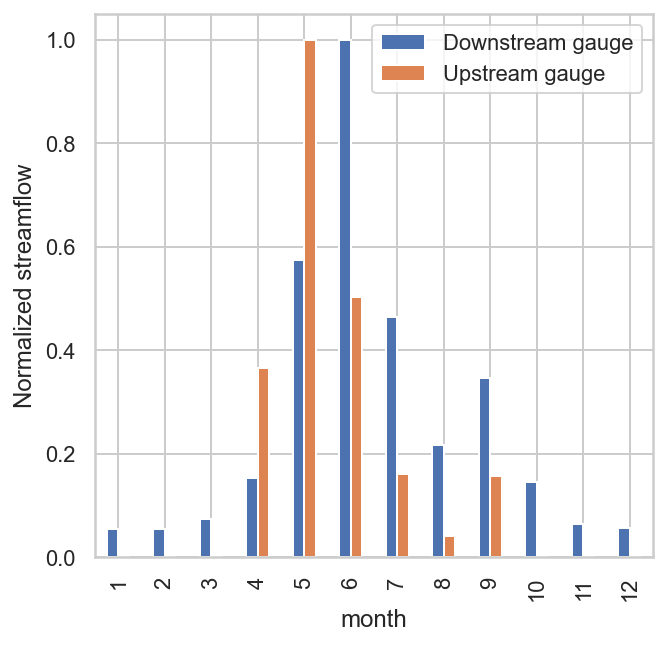

In [13]:
# Plot the monthly streamflow climatology
ax = monthly_climatology['streamflow_norm'].unstack('site'
    ).plot.bar(figsize=[5,5])

# Better plot labels
ax.set_ylabel('Normalized streamflow')
ax.legend(labels = ('Downstream gauge', 'Upstream gauge'))

### How are the monthly streamflow patterns similar for the two gauges? How are they different? Why?

Streamflow at both gauges peaks in the spring and is lower in the summer. The peak for the upstream gauge is earlier in the season, probably because that gauge is in an area where the snow melts out earlier than it does for the rest of the basin.

## Which of the gauges has the most variability (relative to the mean) in monthly and daily streamflow?

### What are the steps to computing and normalizing the daily variability?

1. Group the data by gauge
2. Aggregate by computing the standard deviation and average
3. For each row, compute the relative standard deviation 

### What are the steps to computing and normalizing the monthly variability?

1. Group the data by gauge, month, and year
2. Aggregate by computing the sum of each group
3. Group the data by gauge
4. Aggregate by computing the standard deviation and average
5. For each row, compute the relative standard deviation

### Plot the daily z-score for each gauge

First, let's look at the daily variability visually by computing the daily z-score:

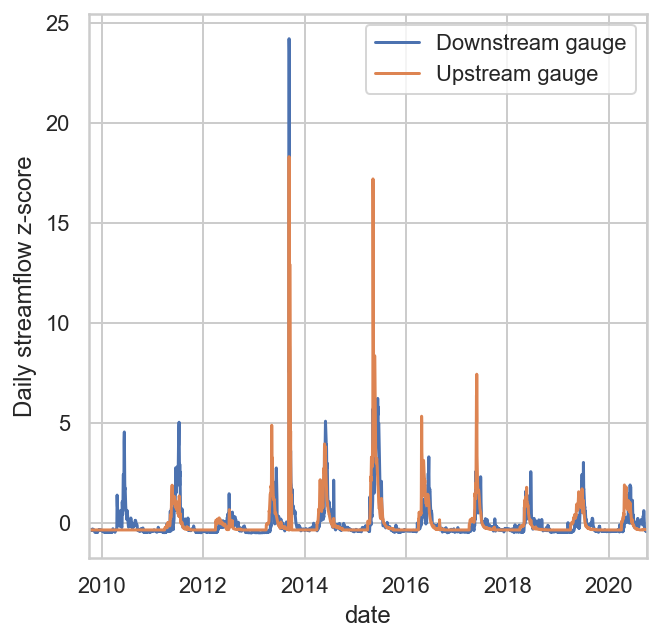

In [14]:
# Compute z-scores for each site
ax = streamflow_df.groupby('site'
    ).transform(lambda x: (x - x.mean()) / x.std()
    # Plot z-scores
    ).unstack('site').plot(figsize=[5,5])

# Better plot labels
ax.set_ylabel('Daily streamflow z-score')
ax.legend(labels = ('Downstream gauge', 'Upstream gauge'))

### Compute the relative standard deviation of daily streamflow at each gauge

In [15]:
# Take the site mean and standard deviation
streamflow_daily_relvar = streamflow_df.groupby('site'
    )[['streamflow']].agg(['std', 'mean'])

# Calculate the relative standard deviation
streamflow_daily_relvar['relvar'] = (
    streamflow_daily_relvar[('streamflow', 'std')] / 
    streamflow_daily_relvar[('streamflow', 'mean')])

streamflow_daily_relvar

streamflow               relvar
                   std       mean          
site                                       
downstream  193.023425  98.047924  1.968664
upstream     16.187579   5.639691  2.870295

### Compute the relative standard deviation of monthly mean streamflow at each gauge

In [16]:
# Take the standard deviation and mean of the monthly mean streamflow
streamflow_monthly_relvar = streamflow_ymd.groupby(['site', 'month', 'year']
    ).agg('mean'
    ).groupby('site'
    ).agg(['std', 'mean'])

# Calculate the relative standard deviation
streamflow_monthly_relvar['relative_std'] = (
    streamflow_monthly_relvar[('streamflow', 'std')] / 
    streamflow_monthly_relvar[('streamflow', 'mean')])

streamflow_monthly_relvar

streamflow            relative_std
                   std       mean             
site                                          
downstream  147.998332  97.965452     1.510720
upstream     12.906915   5.621167     2.296127

### What do you observe about the relative variability of streamflow at each gauge? What about aggregated to different time intervals? Why?

The relative variability is lower at the downstream gauge for both monthly and daily data. This is probably because the stream at the downstream gauge is fed by a larger area and therefore is less sensitive to changes in local conditions. The relative variability at both gauges is lower monthly data. This is probably because the monthly aggregation smooths out any spikes in the daily data.

## Think of an additional way to group and aggregate the streamflow data and implement it, or use grouping and aggregating to analyse your own data